# Model Comparison Across Difficulty Levels

Evaluate all trained models on all curriculum levels and compare performance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sb3_contrib import MaskablePPO
from torch.distributions import Distribution

from apad_puzzle_rl.envs.apad_env import APADEnv
from apad_puzzle_rl.envs.curriculum_env import CurriculumAPADEnv

Distribution.set_default_validate_args(False)

%matplotlib inline

In [18]:
def finish_game(model, pieces_remaining, deterministic, visualize=False):
    """Start from partial board state, play to completion."""
    env = CurriculumAPADEnv(4, 14, pieces_remaining=pieces_remaining)
    obs, info = env.reset()

    done = False
    while not done:
        action, _ = model.predict(
            obs, action_masks=info["action_mask"], deterministic=deterministic
        )
        obs, reward, terminated, truncated, info = APADEnv.step(env, action)
        done = terminated or truncated

    final_pieces_remaining = np.sum(env.remaining_pieces)
    success = terminated

    if visualize:
        env.visualize()
        print(f"Pieces remaining: {final_pieces_remaining}")
        print(f"Success: {success}")

    return final_pieces_remaining, success


def evaluate_model_all_levels(model, n_episodes=100, deterministic=False):
    """Evaluate a model on all curriculum levels.

    Returns:
        dict: {pieces_remaining: success_rate}
    """
    results = {}

    for pieces_remaining in range(2, 8):
        wins = 0
        for _ in range(n_episodes):
            _, success = finish_game(model, pieces_remaining, deterministic, visualize=False)
            wins += success

        success_rate = wins / n_episodes
        results[pieces_remaining] = success_rate
        print(f"  Level {pieces_remaining}: {success_rate:.1%}")

    return results

In [14]:
# Store results for all models
all_results = {}

In [15]:
# Define models to evaluate
model_names = [
    "curriculum_model_lvl2",
    "curriculum_model_lvl3",
    "curriculum_model_lvl4",
    "curriculum_model_lvl5",
    "curriculum_model_lvl6",
    # "curriculum_model_v1",
    # "curriculum_model_v3",
    # "curriculum_model_v4",
    "curriculum_model_v5",
]

# Evaluate each model
for model_name in model_names:
    try:
        print(f"\nEvaluating {model_name}...")
        model = MaskablePPO.load(model_name)
        results = evaluate_model_all_levels(model, n_episodes=1000, deterministic=False)
        all_results[model_name] = results
    except FileNotFoundError:
        print(f"  Model {model_name} not found, skipping")
    except Exception as e:
        print(f"  Error loading {model_name}: {e}")


Evaluating curriculum_model_lvl2...
  Level 2: 99.8%
  Level 3: 82.6%
  Level 4: 50.9%
  Level 5: 21.0%
  Level 6: 8.4%
  Level 7: 2.3%

Evaluating curriculum_model_lvl3...
  Level 2: 98.4%
  Level 3: 96.3%
  Level 4: 80.3%
  Level 5: 49.7%
  Level 6: 21.5%
  Level 7: 8.1%

Evaluating curriculum_model_lvl4...
  Level 2: 97.0%
  Level 3: 92.1%
  Level 4: 82.6%
  Level 5: 64.8%
  Level 6: 42.8%
  Level 7: 31.3%

Evaluating curriculum_model_lvl5...
  Level 2: 99.4%
  Level 3: 94.9%
  Level 4: 84.0%
  Level 5: 76.9%
  Level 6: 57.8%
  Level 7: 46.1%

Evaluating curriculum_model_lvl6...
  Level 2: 98.9%
  Level 3: 96.7%
  Level 4: 91.7%
  Level 5: 83.4%
  Level 6: 77.3%
  Level 7: 71.0%

Evaluating curriculum_model_v5...
  Level 2: 97.1%
  Level 3: 85.7%
  Level 4: 67.2%
  Level 5: 48.9%
  Level 6: 30.3%
  Level 7: 19.8%


In [19]:
model_name = "curriculum_model_lvl7"
try:
    print(f"\nEvaluating {model_name}...")
    model = MaskablePPO.load(model_name)
    results = evaluate_model_all_levels(model, n_episodes=1000, deterministic=False)
    all_results[model_name] = results
except FileNotFoundError:
    print(f"  Model {model_name} not found, skipping")
except Exception as e:
    print(f"  Error loading {model_name}: {e}")


Evaluating curriculum_model_lvl7...
  Level 2: 99.2%
  Level 3: 97.1%
  Level 4: 92.8%
  Level 5: 89.5%
  Level 6: 81.8%
  Level 7: 79.5%


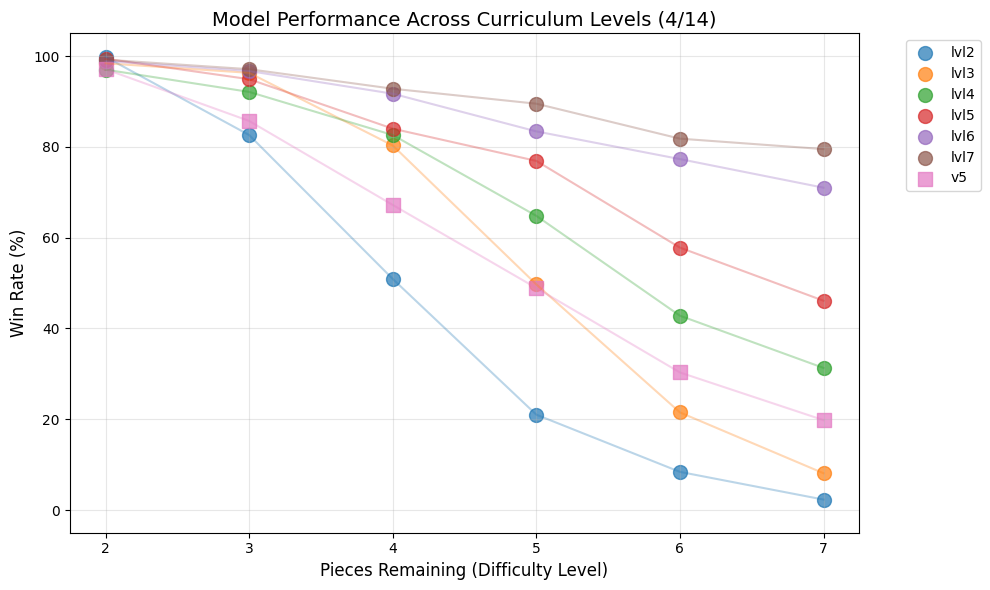

In [30]:
# Plot results
plt.figure(figsize=(10, 6))

for model_name, results in sorted(all_results.items()):
    levels = list(results.keys())
    success_rates = [results[level] * 100 for level in levels]  # Convert to percentage

    # Use different markers for lvl vs v models
    marker = "o" if "lvl" in model_name else "s"
    label = model_name.replace("curriculum_model_", "")

    plt.scatter(levels, success_rates, label=label, marker=marker, s=100, alpha=0.7)
    plt.plot(levels, success_rates, alpha=0.3)

plt.xlabel("Pieces Remaining (Difficulty Level)", fontsize=12)
plt.ylabel("Win Rate (%)", fontsize=12)
plt.title("Model Performance Across Curriculum Levels (4/14)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 8))
plt.ylim(-5, 105)
plt.tight_layout()
plt.savefig("curriculum_model_compare.png")
plt.show()

In [26]:
# Print summary table
print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(f"{'Model':<25} {'L2':<8} {'L3':<8} {'L4':<8} {'L5':<8} {'L6':<8} {'L7':<8}")
print("-" * 80)

for model_name, results in sorted(all_results.items()):
    label = model_name.replace("curriculum_model_", "")
    row = [f"{results.get(i, 0):.1%}" for i in range(2, 8)]
    print(f"{label:<25} {' '.join(f'{r:<8}' for r in row)}")


SUMMARY TABLE
Model                     L2       L3       L4       L5       L6       L7      
--------------------------------------------------------------------------------
lvl2                      99.8%    82.6%    50.9%    21.0%    8.4%     2.3%    
lvl3                      98.4%    96.3%    80.3%    49.7%    21.5%    8.1%    
lvl4                      97.0%    92.1%    82.6%    64.8%    42.8%    31.3%   
lvl5                      99.4%    94.9%    84.0%    76.9%    57.8%    46.1%   
lvl6                      98.9%    96.7%    91.7%    83.4%    77.3%    71.0%   
lvl7                      99.2%    97.1%    92.8%    89.5%    81.8%    79.5%   
v5                        97.1%    85.7%    67.2%    48.9%    30.3%    19.8%   
